pick a range between 0 and 10829: enter start 42 45
you have selected : 42                Selenocysteine synthesis
43                Selenocysteine synthesis
44    ROS and RNS production in phagocytes
Name: pathwayname, dtype: object
Creating heatmap for :  Selenocysteine synthesis


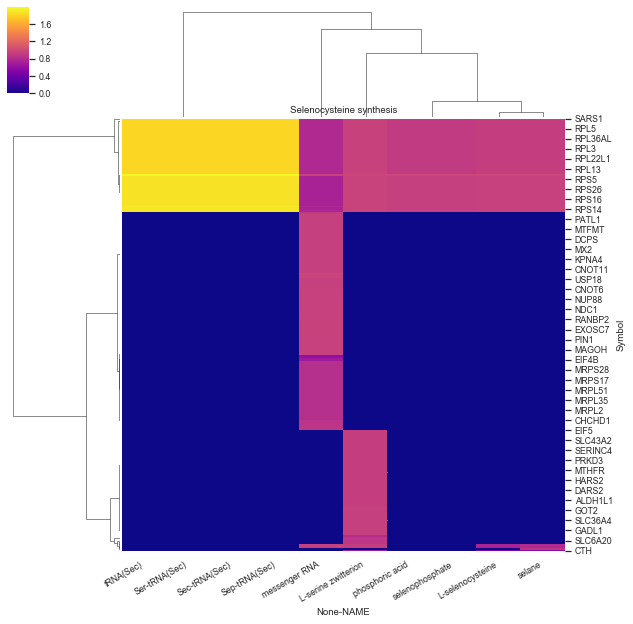

<Figure size 432x288 with 0 Axes>

Creating heatmap for :  Selenocysteine synthesis


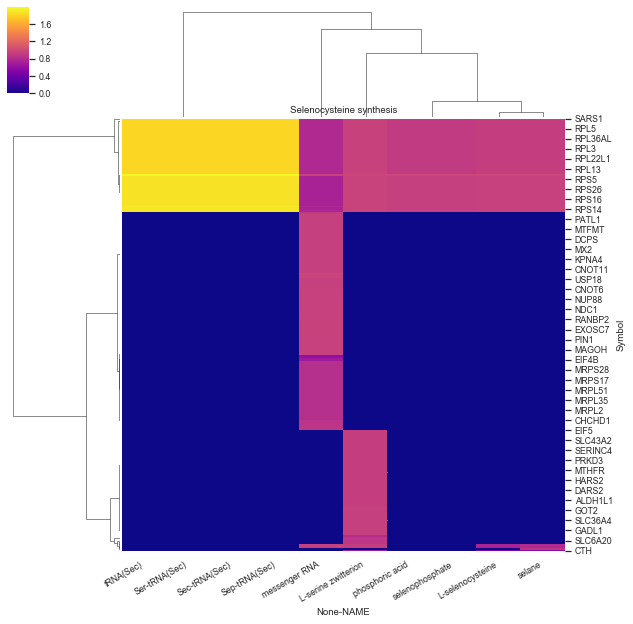

<Figure size 432x288 with 0 Axes>

Creating heatmap for :  ROS and RNS production in phagocytes


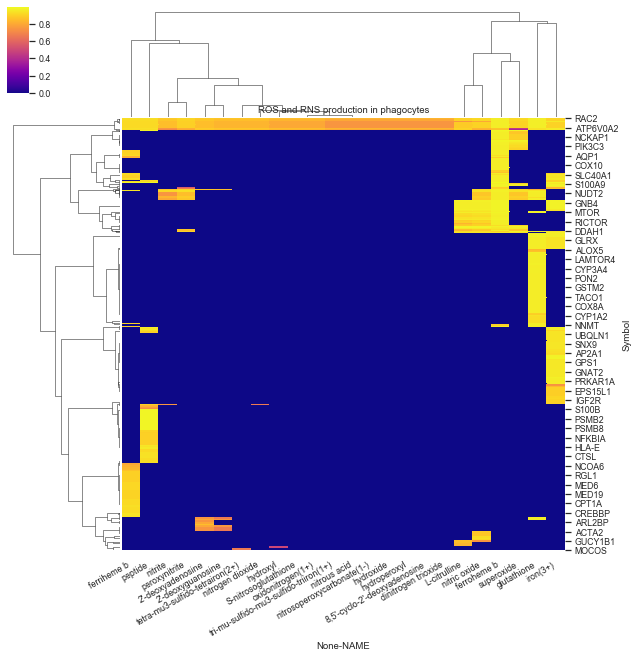

<Figure size 432x288 with 0 Axes>

In [10]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering as AC
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import ward,fcluster,is_valid_linkage
import seaborn as sns; sns.set(color_codes=True)
from matplotlib.backends.backend_pdf import PdfPages

#data from Jaccard script with gene symbols,chebi compound names and Jaccard similairty scores
score_df= pd.read_csv("/Users/anu/Desktop/pathway_score.csv", sep = ',')

#joining the corresponding chebi and gene names with the Id's

chebinames = pd.read_csv("/Users/anu/Desktop/compounds.tsv",sep = '\t',usecols = ['CHEBI_ACCESSION','NAME'])
genenames = pd.read_csv("/Users/anu/Desktop/gene_info.csv",usecols = ['GeneID','Symbol'])

#Joining dataframes
score_chebi= score_df.join(chebinames.set_index('CHEBI_ACCESSION'), on='chebi_id')
finaldf = score_chebi.join(genenames.set_index('GeneID'),on= 'GeneID')

#reading lowest level reactome pathway data
reactome = pd.read_csv("/Users/anu/Desktop/KBJacc_Scorefiles/chebi2Reactome.csv",usecols=['chebi_id','reactomepathway_id','pathwayname'])

# To generate pathway list for the user
# pick_pathway =[]
def user_interface(file,col):
    items = file[col]
    start,stop = input("pick a range between 0 and "+ str(len(reactome)) + ": enter start ").split()
    start = int(start)
    stop = int(stop)
    print("you have selected :", items[int(start):int(stop)])
    #pathways = pick_pathway.append(items[int(start):int(stop)])
    return(items[int(start):int(stop)])

# selecting chebi ids related to the pathway
def data_selector(df1,colname,info):
    #info = index(df1,colname)
    select = df1.loc[df1[colname]==info]
    return(select["chebi_id"])  

# Ignoring the obvious chemical compounds based on their frequency :::
def frequency(df):
    chebinamecounts = finaldf['NAME'].value_counts(sort= True) #.sort_index()
    topnames = chebinamecounts.nlargest(50,keep = "all")
    names= pd.DataFrame(topnames.index, columns = ["NAME"])
    excluded_names = finaldf[~finaldf['NAME'].isin(names["NAME"])]
    return(excluded_names)

#creating distance matrix between the compounds and genes based on pathway association score
def matrix(df1,colname,info,df2,col4):
    collection = data_selector(df1,colname,info)
    selection = pd.DataFrame(collection)
    df3 = selection.join(df2.set_index('chebi_id'),on = 'chebi_id')
    df3["Jaccard_Distance"] = 1-df3[col4]
    matrixx = df3.pivot_table(index = ["Symbol"],values = ['Jaccard_Distance'],columns =['NAME'],aggfunc=sum,fill_value=0.0)
    return(matrixx)

# Creating Heatmap Dendogram :::
def build_heatmap(info):
#     print("this is info:",info)
    clust = matrix(reactome,'pathwayname',info,frequency(finaldf),'Jaccard_Similarity_Score')
#     print(clust)
    symbls = clust.index
    sns.set(font_scale = .8)
    g = sns.clustermap(clust,
                   method = 'ward',
                   metric = 'euclidean',
                   cmap ='plasma',
                   xticklabels=[x[1] for x in clust.columns],
                   figsize = (10,10)
    )
    g.ax_heatmap.set_title(str(info))
    #pp = PdfPages('multiclusters.pdf')
    plt.setp(g.ax_heatmap.get_xticklabels(), ha='right', rotation= 30)# angle the x axis labels
    f = plt.figure()
    s =str(info)
    filename= ''.join(e for e in s if e.isalnum())
    g.savefig(filename +".jpg", bbox_inches='tight')
    plt.show()

#Calling the first function as as user input
def main():
    pathways=[]
    pathways=user_interface(reactome,'pathwayname')
    #print(index(reactome,'pathwayname'))
    for i in pathways:
        print("Creating heatmap for : ", i)
        build_heatmap(i)
                
main()
# opt = matrix(reactome,'pathwayname',info,finaldf,'Jaccard_Similarity_Score')


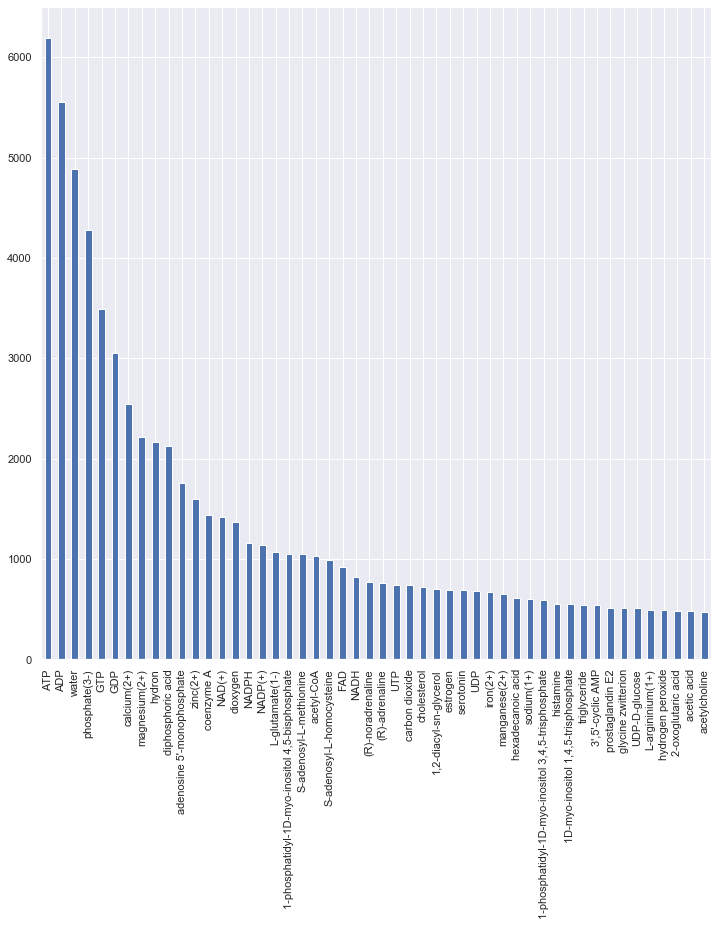

In [8]:
#quick look at the frequency of the chebi compounds
namecounts = finaldf['NAME'].value_counts(sort= True) #.sort_index()
# print(namecounts>1000)
top = namecounts.nlargest(50,keep = "all") #specifying nlargest will give the highest frequency until that n point
x = pd.DataFrame(top.index, columns = ["NAME"])
# print(top)
(top.plot(kind = "bar",figsize = (12,12)))
